# **Reddit Lens - Troll and Bot Predictor Model**
### ***Decision Tree Classifier vs Random Forest Classifier***

#### **Bots and trolls** are becoming a major perril for social platforms nowadays as their hidden influence upon users seems to trigger unforeseeable effects especially in the political realm. 
#### Trolls might be relatively innocent, merely attempting to enjoy themselves at others’ expense, but they can also be political players fostering suspicion or conflict. While some bots provide useful information, others might be employed to rig election results and spread content that furthers their political objectives. The severity of bot issues is anticipated to worsen as machine learning technology advance.
#### In this scenario, I decided to fight fire with fire and develop a Machine Learning model, which I called **Reddit Lens**, for detecting trolls and bots on subreddit threads while I was trying to compare **Decision Tree and Random Forest Classifiers**.

In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from textblob import TextBlob
import datetime as dt
import difflib
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from IPython import get_ipython
import collections
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn import tree
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/redditdata/reddit-data.csv
/kaggle/input/reddit-clean-data/reddit_clean_data (1).csv
/kaggle/input/redditnormaluserdata/reddit_users.csv


## **Data Cleaning and Normalizing (Trolls and Bots DB)**

In [25]:
with open('../input/redditdata/reddit-data.csv') as f:
    df = pd.read_csv(f, sep=',', dtype={
        "banned_by": str,
        "no_follow": bool,
        "link_id": str,
        "gilded": bool,
        "author": str,
        "author_verified": bool,
        "author_comment_karma": np.float64,
        "author_link_karma": np.float64,
        "num_comments": np.float64,
        "created_utc": np.float64,
        "score": np.float64,
        "over_18": bool,
        "body": str,
        "downs": np.float64,
        "is_submitter": bool,
        "num_reports": np.float64,
        "controversiality": np.float64,
        "quarantine": str,
        "ups": np.float64,
        "is_bot": bool,
        "is_troll": bool,
        "recent_comments": str
    })
    
df['created_utc'] = pd.to_datetime(df['created_utc'].values, unit='s')
df = df.assign(is_normal=False)
    
print(f"{df.size} bots and trolls raw comments")
df.head()

6141828 bots and trolls raw comments


banned_by  no_follow    link_id  gilded   author  author_verified  \
0       NaN       True  t3_2l5szg   False  ADHDbot            False   
1       NaN       True  t3_2l61gs   False  ADHDbot            False   
2       NaN       True  t3_2l7ma8   False  ADHDbot            False   
3       NaN       True  t3_2l7t5h   False  ADHDbot            False   
4       NaN       True  t3_2l900k   False  ADHDbot            False   

   author_comment_karma  author_link_karma  num_comments         created_utc  \
0                  -6.0                1.0           1.0 2014-11-03 15:02:38   
1                  -6.0                1.0           1.0 2014-11-03 16:21:27   
2                  -6.0                1.0           1.0 2014-11-04 00:21:05   
3                  -6.0                1.0           1.0 2014-11-04 01:23:18   
4                  -6.0                1.0           1.0 2014-11-04 10:15:33   

   ...  downs  is_submitter num_reports  controversiality  quarantine  ups  \
0  ...    0.0         False         NaN               0.0       false  1.0   
1  ...    0.0         False         NaN               0.0       false  1.0   
2  ...    0.0         False         NaN               0.0       false  1.0   
3  ...    0.0         False         NaN               0.0       false  1.0   
4  ...    0.0         False         NaN               0.0       false  1.0   

   is_bot is_troll                                    recent_comments  \
0    True    False                                                 []   
1    True    False  [{"banned_by":null,"no_follow":true,"link_id":...   
2    True    False  [{"banned_by":null,"no_follow":true,"link_id":...   
3    True    False  [{"banned_by":null,"no_follow":true,"link_id":...   
4    True    False  [{"banned_by":null,"no_follow":true,"link_id":...   

   is_normal  
0      False  
1      False  
2      False  
3      False  
4      False  

[5 rows x 23 columns]

## **Data Cleaning and Normalizing (Normal Users DB)**

In [26]:
with open('../input/redditnormaluserdata/reddit_users.csv') as f:
    df_normal = pd.read_csv(f, sep=',', dtype={
        "banned_by": str,
        "no_follow": bool,
        "link_id": str,
        "gilded": bool,
        "author": str,
        "author_verified": bool,
        "author_comment_karma": np.float64,
        "author_link_karma": np.float64,
        "num_comments": np.float64,
        "created_utc": np.float64,
        "score": np.float64,
        "over_18": bool,
        "body": str,
        "downs": np.float64,
        "is_submitter": bool,
        "num_reports": np.float64,
        "controversiality": np.float64,
        "quarantine": str,
        "ups": np.float64,
        "recent_comments": str
    })

df_normal = df_normal.assign(is_bot=False, is_troll=False, is_normal=True)
df_normal['created_utc'] = pd.to_datetime(df_normal['created_utc'].values, unit='s')
    
print(f"{df_normal.size} normal users raw comments")
df_normal.head()

926762 normal users raw comments


banned_by  no_follow    link_id  gilded             author  author_verified  \
0       NaN       True  t3_zfmq3a   False   IFUCKINGLOVEMETH             True   
1       NaN       True  t3_zfpm82   False    Takethemagsaway             True   
2       NaN       True  t3_zfmmhn   False  CassandraAnderson             True   
3       NaN       True  t3_zfculp   False          tanman729             True   
4       NaN       True  t3_zfmx4g   False     BassReasonable             True   

   author_comment_karma  author_link_karma  num_comments         created_utc  \
0               74046.0            33501.0          98.0 2022-12-08 06:37:57   
1               24895.0               39.0          14.0 2022-12-08 06:37:59   
2              225735.0             7531.0          41.0 2022-12-08 06:38:07   
3               17750.0             1671.0          63.0 2022-12-08 06:37:54   
4                2264.0               31.0          65.0 2022-12-08 06:37:19   

   ...  downs  is_submitter num_reports  controversiality  quarantine  ups  \
0  ...    0.0         False         NaN               0.0       False  1.0   
1  ...    0.0         False         NaN               0.0       False  1.0   
2  ...    0.0         False         NaN               0.0       False  1.0   
3  ...    0.0         False         NaN               0.0       False  1.0   
4  ...    0.0         False         NaN               0.0       False  1.0   

   is_bot is_troll                                    recent_comments  \
0   False    False  [{"banned_by":null,"no_follow":true,"link_id":...   
1   False    False  [{"banned_by":null,"no_follow":true,"link_id":...   
2   False    False  [{"banned_by":null,"no_follow":true,"link_id":...   
3   False    False  [{"banned_by":null,"no_follow":false,"link_id"...   
4   False    False  [{"banned_by":null,"no_follow":true,"link_id":...   

   is_normal  
0       True  
1       True  
2       True  
3       True  
4       True  

[5 rows x 23 columns]

In [27]:
# append normal users to bot/trolls
df = df.append(df_normal)

df.drop_duplicates(inplace=True)
df['body'] = df['body'].str.slice(stop=200).fillna('')

# add a few useful statistics features
df['recent_num_comments'] = pd.Series(np.zeros(len(df.index), np.int64))
df['recent_num_last_30_days'] = pd.Series(np.zeros(len(df.index), np.int64))
df['recent_avg_no_follow'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_gilded'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_responses'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_percent_neg_score'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_score'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_min_score'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_controversiality'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_ups'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_diff_ratio'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_max_diff_ratio'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_sentiment_polarity'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_min_sentiment_polarity'] = pd.Series(np.zeros(len(df.index), np.float64))

6141828
7068590


In [28]:
# Comments
bot_comments = df['is_bot'][df.is_bot == True]
troll_comments = df['is_troll'][df.is_troll == True]
normal_comments = df['is_normal'][df.is_normal == True]

print(f"Number of bot comments: {len(bot_comments)}")
print(f"Number of troll comments: {len(troll_comments)}")
print(f"Number of normal comments: {len(normal_comments)}")

# Authors
bot_authors = df[df.is_bot == True][['author']]
troll_authors = df[df.is_troll == True][['author']]
normal_authors = df[df.is_normal == True][['author']]

print(f"\nNumber of bot authors: {len(np.unique(bot_authors))}")
print(f"Number of troll authors: {len(np.unique(troll_authors))}")
print(f"Number of normal authors: {len(np.unique(normal_authors))}")

users = df['author'].values
print(f"Total number of users: {len(np.unique(users))}")

Number of bot comments: 221074
Number of troll comments: 6563
Number of normal comments: 27497

Number of bot authors: 343
Number of troll authors: 153
Number of normal authors: 15997
Total number of users: 16492


In [29]:
def diff_ratio(_a, _b):
    return difflib.SequenceMatcher(a=_a,b=_b).ratio()

def last_30(a, b):
    return a - dt.timedelta(days=30) < pd.to_datetime(b, unit='s')

num = 0

# computing our added statistics features
def calc_stats(comment):
    # track progress
    global num 
    num += 1
    if num % 1000 == 0: print(num)
        
    recent_comments = pd.read_json(StringIO(comment['recent_comments']), dtype={
        "banned_by": str,
        "no_follow": bool,
        "link_id": str,
        "gilded": np.float64,
        "author": str,
        "author_verified": bool,
        "author_comment_karma": np.float64,
        "author_link_karma": np.float64,
        "num_comments": np.float64,
        "created_utc": np.float64,
        "score": np.float64,
        "over_18": bool,
        "body": str,
        "downs": np.float64,
        "is_submitter": bool,
        "num_reports": np.float64,
        "controversiality": np.float64,
        "quarantine": bool,
        "ups": np.float64})
    comment['recent_num_comments'] = len(recent_comments)
    
    if len(recent_comments) > 0:
        comment['recent_num_last_30_days'] = recent_comments['created_utc'].apply(lambda x: last_30(comment['created_utc'], x)).sum()
        comment['recent_avg_no_follow'] = recent_comments['no_follow'].mean()
        comment['recent_avg_gilded'] = recent_comments['gilded'].mean()
        comment['recent_avg_responses'] = recent_comments['num_comments'].mean()
        comment['recent_percent_neg_score'] = recent_comments['score'].apply(lambda x: x < 0).mean() * 100
        comment['recent_avg_score'] = recent_comments['score'].mean()
        comment['recent_min_score'] = recent_comments['score'].min()
        comment['recent_avg_controversiality'] = recent_comments['controversiality'].mean()
        comment['recent_avg_ups'] = recent_comments['ups'].mean()
        diff = recent_comments['body'].str.slice(stop=200).fillna('').apply(lambda x: diff_ratio(comment['body'], x))
        comment['recent_avg_diff_ratio'] = diff.mean()
        comment['recent_max_diff_ratio'] = diff.max()
        scores = recent_comments['body'].append(pd.Series(comment['body'])).apply(lambda x: TextBlob(x).sentiment.polarity)
        comment['recent_avg_sentiment_polarity'] = scores.mean()
        comment['recent_min_sentiment_polarity'] = scores.min()
        
    return comment

new_data = df.apply(calc_stats, axis=1)
print("Stats Computation is ready!")

# delete NA values
new_data = new_data[new_data.recent_min_sentiment_polarity.isna() == False]

def setTarget(x):
    if x.is_bot:
        return 'bot'
    elif x.is_troll:
        return 'troll' 
    else:
        return 'normal'

# Create one column with the target training label
new_data['target'] = new_data.apply(lambda x: setTarget(x), axis=1)

# Delete is_bot and is_troll columns and add targets column
columns = ['is_bot', 'is_troll', 'is_normal']
new_data.drop(columns, inplace=True, axis=1)

# Delete recent_comments to save space
columns = ['recent_comments']
new_data.drop(columns, inplace=True, axis=1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [3]:
new_data.to_csv('./reddit_clean_data.csv', sep=',', index=False)
print("The data cleaning finished correctly!!!")

The data cleaning finished correctly!!!


## **Model Training**

In [42]:
with open('../input/reddit-clean-data/reddit_clean_data (1).csv') as f:
    df = pd.read_csv(f, sep=',')
    
columns = ['banned_by', 'num_reports', 'created_utc']
df.drop(columns, inplace=True, axis=1)
df.dropna(inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255045 entries, 0 to 255125
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   no_follow                      255045 non-null  bool   
 1   link_id                        255045 non-null  object 
 2   gilded                         255045 non-null  bool   
 3   author                         255045 non-null  object 
 4   author_verified                255045 non-null  bool   
 5   author_comment_karma           255045 non-null  float64
 6   author_link_karma              255045 non-null  float64
 7   num_comments                   255045 non-null  float64
 8   score                          255045 non-null  float64
 9   over_18                        255045 non-null  bool   
 10  body                           255045 non-null  object 
 11  downs                          255045 non-null  float64
 12  is_submitter                  

no_follow    link_id  gilded   author  author_verified  \
0       True  t3_2l5szg   False  ADHDbot            False   
1       True  t3_2l61gs   False  ADHDbot            False   
2       True  t3_2l7ma8   False  ADHDbot            False   
3       True  t3_2l7t5h   False  ADHDbot            False   
4       True  t3_2l900k   False  ADHDbot            False   

   author_comment_karma  author_link_karma  num_comments  score  over_18  ...  \
0                  -6.0                1.0           1.0    1.0    False  ...   
1                  -6.0                1.0           1.0    1.0    False  ...   
2                  -6.0                1.0           1.0    1.0    False  ...   
3                  -6.0                1.0           1.0    1.0    False  ...   
4                  -6.0                1.0           1.0    1.0    False  ...   

  recent_percent_neg_score  recent_avg_score  recent_min_score  \
0                      0.0               0.0               0.0   
1                      0.0               1.0               1.0   
2                      0.0               1.0               1.0   
3                      0.0               1.0               1.0   
4                      0.0               1.0               1.0   

   recent_avg_controversiality  recent_avg_ups  recent_avg_diff_ratio  \
0                          0.0             0.0               0.000000   
1                          0.0             1.0               0.025000   
2                          0.0             1.0               0.517500   
3                          0.0             1.0               0.678333   
4                          0.0             1.0               0.035000   

   recent_max_diff_ratio  recent_avg_sentiment_polarity  \
0                  0.000                       0.000000   
1                  0.025                       0.133333   
2                  1.000                       0.144444   
3                  1.000                       0.150000   
4                  0.050                       0.130000   

   recent_min_sentiment_polarity  target  
0                           0.00     bot  
1                           0.10     bot  
2                           0.10     bot  
3                           0.10     bot  
4                           0.05     bot  

[5 rows x 31 columns]

In [43]:
df[df['target'] == 'bot'].describe()

author_comment_karma  author_link_karma   num_comments          score  \
count         220985.000000      220985.000000  220985.000000  220985.000000   
mean           36217.840057       14923.552295     325.566962       4.351675   
std            87940.207201       77343.578258    1487.203989      32.244344   
min             -100.000000           1.000000       1.000000    -360.000000   
25%              700.000000           1.000000       2.000000       1.000000   
50%             4637.000000           5.000000      17.000000       1.000000   
75%            23437.000000         126.000000     119.000000       2.000000   
max           582974.000000      849774.000000   55429.000000    3390.000000   

          downs  controversiality            ups  recent_num_comments  \
count  220985.0     220985.000000  220985.000000        220985.000000   
mean        0.0          0.014481       4.351675            19.643573   
std         0.0          0.119461      32.244344             2.181980   
min         0.0          0.000000    -360.000000             0.000000   
25%         0.0          0.000000       1.000000            20.000000   
50%         0.0          0.000000       1.000000            20.000000   
75%         0.0          0.000000       2.000000            20.000000   
max         0.0          1.000000    3390.000000            20.000000   

       recent_num_last_30_days  recent_avg_no_follow  ...  \
count            220985.000000         220985.000000  ...   
mean                 19.174559              0.880828  ...   
std                   3.238745              0.179626  ...   
min                   0.000000              0.000000  ...   
25%                  20.000000              0.850000  ...   
50%                  20.000000              0.950000  ...   
75%                  20.000000              1.000000  ...   
max                  20.000000              1.000000  ...   

       recent_avg_responses  recent_percent_neg_score  recent_avg_score  \
count         220985.000000             220985.000000     220985.000000   
mean             323.359092                  3.132156          4.371648   
std             1204.007151                  8.557954         12.468101   
min                0.000000                  0.000000        -49.500000   
25%                8.800000                  0.000000          1.000000   
50%               51.200000                  0.000000          1.500000   
75%              246.750000                  0.000000          3.200000   
max            22185.550000                100.000000        618.000000   

       recent_min_score  recent_avg_controversiality  recent_avg_ups  \
count     220985.000000                220985.000000   220985.000000   
mean          -1.030441                     0.014569        4.371648   
std            8.276641                     0.042654       12.468101   
min         -360.000000                     0.000000      -49.500000   
25%            0.000000                     0.000000        1.000000   
50%            1.000000                     0.000000        1.500000   
75%            1.000000                     0.000000        3.200000   
max          351.000000                     1.000000      618.000000   

       recent_avg_diff_ratio  recent_max_diff_ratio  \
count          220985.000000          220985.000000   
mean                0.591264               0.771673   
std                 0.290730               0.255620   
min                 0.000000               0.000000   
25%                 0.356750               0.605000   
50%                 0.601323               0.890000   
75%                 0.865783               0.975000   
max                 1.000000               1.000000   

       recent_avg_sentiment_polarity  recent_min_sentiment_polarity  
count                  220985.000000                  220985.000000  
mean                        0.049792                      -0.166379  
std                         0.195352           

In [44]:
df[df['target'] == 'troll'].describe()

author_comment_karma  author_link_karma  num_comments         score  \
count           6563.000000        6563.000000   6563.000000   6563.000000   
mean            1872.454365       13253.685357    476.881152     17.949718   
std             5480.704868       16990.166808   2391.579689    499.305178   
min              -20.000000           1.000000      1.000000   -145.000000   
25%              108.000000         366.000000      7.000000      1.000000   
50%              453.000000        1487.000000     31.000000      1.000000   
75%             1138.000000       20663.000000    191.000000      2.000000   
max            32373.000000       45367.000000  75370.000000  22893.000000   

        downs  controversiality           ups  recent_num_comments  \
count  6563.0       6563.000000   6563.000000          6563.000000   
mean      0.0          0.037330     17.949718            17.202804   
std       0.0          0.189585    499.305178             5.839349   
min       0.0          0.000000   -145.000000             0.000000   
25%       0.0          0.000000      1.000000            20.000000   
50%       0.0          0.000000      1.000000            20.000000   
75%       0.0          0.000000      2.000000            20.000000   
max       0.0          1.000000  22893.000000            20.000000   

       recent_num_last_30_days  recent_avg_no_follow  ...  \
count              6563.000000           6563.000000  ...   
mean                 16.195185              0.908841  ...   
std                   6.363458              0.177195  ...   
min                   0.000000              0.000000  ...   
25%                  14.000000              0.900000  ...   
50%                  20.000000              0.950000  ...   
75%                  20.000000              1.000000  ...   
max                  20.000000              1.000000  ...   

       recent_avg_responses  recent_percent_neg_score  recent_avg_score  \
count           6563.000000               6563.000000       6563.000000   
mean             479.565610                  8.223638         17.603796   
std              843.671628                 12.266532        232.647935   
min                0.000000                  0.000000        -10.000000   
25%               33.850000                  0.000000          1.000000   
50%              137.450000                  5.000000          1.500000   
75%              567.341667                 10.000000          2.650000   
max             8548.000000                100.000000       4330.850000   

       recent_min_score  recent_avg_controversiality  recent_avg_ups  \
count       6563.000000                  6563.000000     6563.000000   
mean          -3.708213                     0.037894       17.603796   
std           10.604944                     0.070198      232.647935   
min         -145.000000                     0.000000      -10.000000   
25%           -5.000000                     0.000000        1.000000   
50%           -1.000000                     0.000000        1.500000   
75%            0.000000                     0.050000        2.650000   
max          174.000000                     1.000000     4330.850000   

       recent_avg_diff_ratio  recent_max_diff_ratio  \
count            6563.000000            6563.000000   
mean                0.178661               0.338565   
std                 0.063724               0.126211   
min                 0.000000               0.000000   
25%                 0.150000               0.290909   
50%                 0.184289               0.333333   
75%                 0.214259               0.378788   
max                 0.800000               1.000000   

       recent_avg_sentiment_polarity  recent_min_sentiment_polarity  
count                    6563.000000                    6563.000000  
mean                        0.114168                      -0.417268  
std                         0.097433                       0.287153  
min                   

In [45]:
df[df['target'] == 'normal'].describe()

author_comment_karma  author_link_karma  num_comments         score  \
count          2.749700e+04       2.749700e+04  27497.000000  27497.000000   
mean           4.312132e+04       1.215845e+04   1920.796014      1.001055   
std            1.580817e+05       2.087989e+05   5398.891587      0.043891   
min           -1.000000e+02       1.000000e+00      0.000000      0.000000   
25%            5.680000e+02       4.000000e+00      9.000000      1.000000   
50%            6.062000e+03       2.470000e+02     57.000000      1.000000   
75%            3.219400e+04       2.412000e+03    725.000000      1.000000   
max            5.703925e+06       1.487922e+07  43690.000000      4.000000   

         downs  controversiality           ups  recent_num_comments  \
count  27497.0           27497.0  27497.000000         27497.000000   
mean       0.0               0.0      1.001055            19.068117   
std        0.0               0.0      0.043891             3.525157   
min        0.0               0.0      0.000000             1.000000   
25%        0.0               0.0      1.000000            20.000000   
50%        0.0               0.0      1.000000            20.000000   
75%        0.0               0.0      1.000000            20.000000   
max        0.0               0.0      4.000000            20.000000   

       recent_num_last_30_days  recent_avg_no_follow  ...  \
count             27497.000000          27497.000000  ...   
mean                 17.603993              0.736902  ...   
std                   5.362570              0.281298  ...   
min                   1.000000              0.000000  ...   
25%                  20.000000              0.650000  ...   
50%                  20.000000              0.850000  ...   
75%                  20.000000              0.950000  ...   
max                  20.000000              1.000000  ...   

       recent_avg_responses  recent_percent_neg_score  recent_avg_score  \
count          27497.000000              27497.000000      27497.000000   
mean            1283.202940                  2.721666          8.563952   
std             2355.250831                  5.645370         35.718576   
min                1.000000                  0.000000        -26.650000   
25%               79.300000                  0.000000          1.200000   
50%              466.300000                  0.000000          2.450000   
75%             1491.250000                  5.000000          6.300000   
max            36264.000000                 85.000000       2375.000000   

       recent_min_score  recent_avg_controversiality  recent_avg_ups  \
count      27497.000000                 27497.000000    27497.000000   
mean          -2.030622                     0.015788        8.563952   
std           10.657751                     0.035938       35.718576   
min         -561.000000                     0.000000      -26.650000   
25%           -1.000000                     0.000000        1.200000   
50%            0.000000                     0.000000        2.450000   
75%            1.000000                     0.000000        6.300000   
max            2.000000                     0.450000     2375.000000   

       recent_avg_diff_ratio  recent_max_diff_ratio  \
count           27497.000000           27497.000000   
mean                0.223312               0.997606   
std                 0.103284               0.042591   
min                 0.028000               0.060000   
25%                 0.179527               1.000000   
50%                 0.212592               1.000000   
75%                 0.245605               1.000000   
max                 1.000000               1.000000   

       recent_avg_sentiment_polarity  recent_min_sentiment_polarity  
count                   27497.000000                   27497.000000  
mean                        0.072883                      -0.433156  
std                         0.084966                       0.264219  
min          

In [46]:
# Number of targets
targets = collections.Counter(df['target'])
print(targets)

# Extract feature and target np arrays (inputs for placeholders)
input_y = df['target'].values
input_x = df.drop(['target'], axis=1)

# Convert categorical data to numeric data using LabelEncoder
def label_encode(data_frame):
    le = preprocessing.LabelEncoder()
    for column_name in data_frame.columns:
        if data_frame[column_name].dtype == object:
            data_frame[column_name] = le.fit_transform(data_frame[column_name])
        else:
            pass

Counter({'bot': 220985, 'normal': 27497, 'troll': 6563})


### **Decision Tree Classifier Model**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(input_x, input_y, test_size=0.3, random_state=16)

# Create a Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=5, criterion='entropy',
                             class_weight={'bot': 2.5, 'troll': 5, 'normal': 15}, 
                             min_samples_leaf=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
label_encode(X_train)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={'bot': 2.5, 'normal': 15, 'troll': 5},
                       criterion='entropy', max_depth=5, min_samples_leaf=100)

### Prediction on Test Set

In [48]:
# prediction on test set
label_encode(X_test)
y_pred = tree_clf.predict(X_test)
y_true = y_test

# confusion matrix
print('\n------------------Confusion Matrix------------------')
matrix = pd.crosstab(y_true, y_pred, rownames=['True'],
                     colnames=['Predicted'], margins=True)
print(matrix)

# classification report
print('\n------------------Classification Report------------------')
print(classification_report(y_true, y_pred))

# feature importance
feature_imp = pd.Series(
        tree_clf.feature_importances_,
        index=df.columns.drop('target')).sort_values(ascending=False)
print(feature_imp)


------------------Confusion Matrix------------------
Predicted    bot  normal  troll    All
True                                  
bot        65785       6    437  66228
normal      3363    3891   1029   8283
troll         94      27   1882   2003
All        69242    3924   3348  76514

------------------Classification Report------------------
              precision    recall  f1-score   support

         bot       0.95      0.99      0.97     66228
      normal       0.99      0.47      0.64      8283
       troll       0.56      0.94      0.70      2003

    accuracy                           0.94     76514
   macro avg       0.83      0.80      0.77     76514
weighted avg       0.94      0.94      0.93     76514

link_id                          0.857200
author_verified                  0.092551
author_comment_karma             0.042693
author                           0.003432
recent_max_diff_ratio            0.003202
body                             0.000922
no_follow           

### Prediction on Training Set

In [49]:
# prediction on training set
y_pred = tree_clf.predict(X_train)
y_true = y_train

# confusion matrix
print('\n------------------Confusion Matrix------------------')
matrix = pd.crosstab(y_true, y_pred, rownames=['True'],
                     colnames=['Predicted'], margins=True)
print(matrix)

# classification report
print('\n------------------Classification Report------------------')
print(classification_report(y_true, y_pred))


------------------Confusion Matrix------------------
Predicted     bot  normal  troll     All
True                                    
bot        154449     156    152  154757
normal          9   19200      5   19214
troll           0      59   4501    4560
All        154458   19415   4658  178531

------------------Classification Report------------------
              precision    recall  f1-score   support

         bot       1.00      1.00      1.00    154757
      normal       0.99      1.00      0.99     19214
       troll       0.97      0.99      0.98      4560

    accuracy                           1.00    178531
   macro avg       0.99      0.99      0.99    178531
weighted avg       1.00      1.00      1.00    178531



### Decision Tree Classifier Diagram

In [1]:
estimator = tree_clf

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = df.drop(['target'], axis=1).columns.values,
                class_names = np.array(['bot','troll', 'normal']),
                rounded = True, proportion = True, 
                precision = 5, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

NameError: name 'tree_clf' is not defined

### Check for overfitting/underfitting

In [52]:
print('Training set score: {:.4f}'.format(tree_clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(tree_clf.score(X_test, y_test)))

Training set score: 0.9979
Test set score: 0.9352


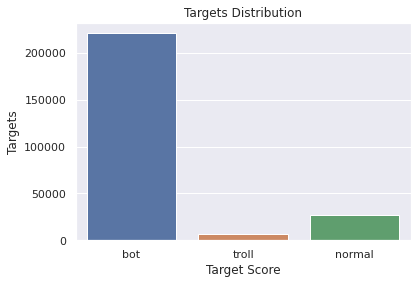

In [53]:
# Plot number of targets
from IPython import get_ipython
import matplotlib.pyplot as plt

ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')

    # Creating a bar plot
    sns.set(style="darkgrid")
    sns.countplot(x="target", data=df)

    # Add labels to your graph
    plt.xlabel('Target Score')
    plt.ylabel('Targets')
    plt.title("Targets Distribution")
    plt.show()

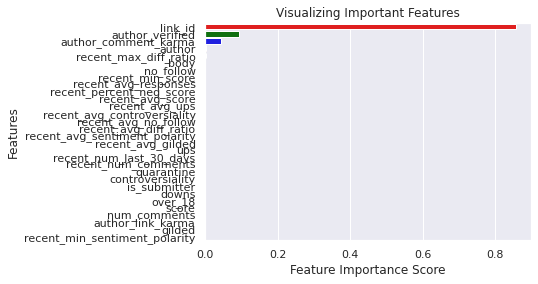

In [54]:
# Visualize the feature importance
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    
    # Creating a bar plot
    fig, ax = plt.subplots()
    ax = sns.barplot(ax=ax, x=feature_imp, y=feature_imp.index, palette=['red', 'green', 'blue'])
    ax.set_box_aspect(20/len(ax.patches))
    
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

### **Random Forest Classifier Model**

In [55]:
# Creating RandomForestClassifier
forest_clf = RandomForestClassifier(criterion = 'entropy',
                               n_estimators = 30, # The number of Decision tree
                               random_state = 10,
                               n_jobs = 3) # Parallelizing model training
forest_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=30, n_jobs=3,
                       random_state=10)

### Prediction on Test Set

In [56]:
y_pred = forest_clf.predict(X_test)
y_true = y_test

# confusion matrix
print('\n------------------Confusion Matrix------------------')
matrix = pd.crosstab(y_true, y_pred, rownames=['True'],
                     colnames=['Predicted'], margins=True)
print(matrix)

# classification report
print('\n------------------Classification Report------------------')
print(classification_report(y_true, y_pred))

# feature importance
feature_imp = pd.Series(
        forest_clf.feature_importances_,
        index=df.columns.drop('target')).sort_values(ascending=False)
print(feature_imp)


------------------Confusion Matrix------------------
Predicted    bot  normal  troll    All
True                                  
bot        66224       0      4  66228
normal      4534    2314   1435   8283
troll         32       5   1966   2003
All        70790    2319   3405  76514

------------------Classification Report------------------
              precision    recall  f1-score   support

         bot       0.94      1.00      0.97     66228
      normal       1.00      0.28      0.44      8283
       troll       0.58      0.98      0.73      2003

    accuracy                           0.92     76514
   macro avg       0.84      0.75      0.71     76514
weighted avg       0.93      0.92      0.90     76514

link_id                          0.359217
author_verified                  0.304330
recent_max_diff_ratio            0.116231
recent_avg_diff_ratio            0.061685
author_comment_karma             0.043774
author_link_karma                0.022771
ups                 

### Prediction on Training Set

In [57]:
# prediction on training set
y_pred = tree_clf.predict(X_train)
y_true = y_train

# confusion matrix
print('\n------------------Confusion Matrix------------------')
matrix = pd.crosstab(y_true, y_pred, rownames=['True'],
                     colnames=['Predicted'], margins=True)
print(matrix)

# classification report
print('\n------------------Classification Report------------------')
print(classification_report(y_true, y_pred))


------------------Confusion Matrix------------------
Predicted     bot  normal  troll     All
True                                    
bot        154449     156    152  154757
normal          9   19200      5   19214
troll           0      59   4501    4560
All        154458   19415   4658  178531

------------------Classification Report------------------
              precision    recall  f1-score   support

         bot       1.00      1.00      1.00    154757
      normal       0.99      1.00      0.99     19214
       troll       0.97      0.99      0.98      4560

    accuracy                           1.00    178531
   macro avg       0.99      0.99      0.99    178531
weighted avg       1.00      1.00      1.00    178531



### Check for overfitting/underfitting

In [58]:
print('Training set score: {:.4f}'.format(forest_clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(forest_clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9215


### Random Forest Classifier Estimators Diagrams

In [59]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (10,10), dpi = 900)
for index in range(0, 4):
    tree.plot_tree(forest_clf.estimators_[index],
                   feature_names = df.drop(['target'], axis=1).columns.values, 
                   class_names = np.array(['bot','troll', 'normal']),
                   rounded = True, proportion = True, 
                   precision = 5, filled = True,
                   ax = axes[index])

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

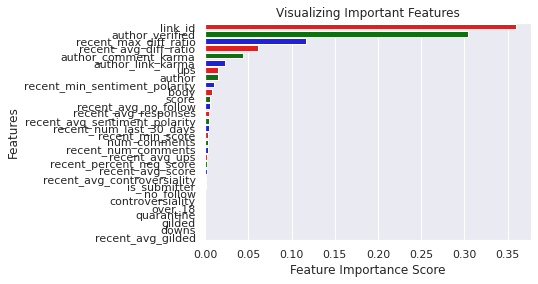

In [60]:
# Visualize the feature importance
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    
    # Creating a bar plot
    fig, ax = plt.subplots()
    ax = sns.barplot(ax=ax, x=feature_imp, y=feature_imp.index, palette=['red', 'green', 'blue'])
    ax.set_box_aspect(20/len(ax.patches))
    
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

### **Serialize model**

In [61]:
with open('./model.pickle', 'wb') as mof:
    pickle.dump(forest_clf, mof)
    mof.close()

## **What's next?**

#### I also developed a **Flask Web API** which exposes the **Reddit Lens ML model** and a **Kafka Cluster** for real-time data streaming to be used by a **Flutter Dashboard Monitor app** in order to help moderators detect trolls and bots on their beloved subreddits. Go check it out on [my github profile](https://github.com/WarriorsSami/reddit_lens)! ;)